# Multi-regression of the metabolites concentrations

### Install project packages

In [1]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


### Install required python modules

In [ ]:
%%bash
pip install -r ../requirements.txt

In [7]:
%%bash
pip install tensorflow==2.4.0

  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


ERROR: tensorflow-gpu 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
tf.__version__

'2.5.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Import fucntions

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import joblib

from tfrecords import write_tfrecords_concentrations, read_tfrecords_concentrations
from models import get_simple_mutli_regressor_mlp, CheckpointCallback

---
# II. Read the tf.Record files

## II.3 Large independent dataset (10000 spectra)

In [27]:
large_train_file_paths = ['../../data/tfrecords/Concentrations_data/Large_sample/train/data_{}.tfrecord'.format(i) 
                        for i in range(32)]
large_val_file_paths = ['../../data/tfrecords/Concentrations_data/Large_sample/validation/data_{}.tfrecord'.format(i) 
                      for i in range(8)]

large_train_dataset = read_tfrecords_concentrations(large_train_file_paths)
large_train_dataset = large_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_val_dataset = read_tfrecords_concentrations(large_val_file_paths)
large_val_dataset = large_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.4 Large correlated dataset (10000 spectra)

In [28]:
large_corr_train_file_paths = ['../../data/tfrecords/Concentrations_data/Large_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(32)]
large_corr_val_file_paths = ['../../data/tfrecords/Concentrations_data/Large_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(8)]

large_corr_train_dataset = read_tfrecords_concentrations(large_corr_train_file_paths)
large_corr_train_dataset = large_corr_train_dataset.batch(128).shuffle(10000).prefetch(tf.data.experimental.AUTOTUNE)

large_corr_val_dataset = read_tfrecords_concentrations(large_corr_val_file_paths)
large_corr_val_dataset = large_corr_val_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

## II.5 Extra small independent dataset (100 spectra)

In [29]:
xsmall_train_file_paths = ['../../data/tfrecords/Concentrations_data/Extra_small_sample/train/data_{}.tfrecord'
                           .format(i) for i in range(4)]
xsmall_val_file_paths = ['../../data/tfrecords/Concentrations_data/Extra_small_sample/validation/data_{}.tfrecord'
                         .format(i) for i in range(1)]

xsmall_train_dataset = read_tfrecords_concentrations(xsmall_train_file_paths)
xsmall_train_dataset = xsmall_train_dataset.batch(8).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_val_dataset = read_tfrecords_concentrations(xsmall_val_file_paths)
xsmall_val_dataset = xsmall_val_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## II.6 Extra small correlated dataset (100 spectra)

In [30]:
xsmall_corr_train_file_paths = ['../../data/tfrecords/Concentrations_data/Extra_small_correlated/train/data_{}.tfrecord'
                               .format(i) for i in range(4)]
xsmall_corr_val_file_paths = ['../../data/tfrecords/Concentrations_data/Extra_small_correlated/validation/data_{}.tfrecord'
                             .format(i) for i in range(1)]

xsmall_corr_train_dataset = read_tfrecords_concentrations(xsmall_corr_train_file_paths)
xsmall_corr_train_dataset = xsmall_corr_train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

xsmall_corr_val_dataset = read_tfrecords_concentrations(xsmall_corr_val_file_paths)
xsmall_corr_val_dataset = xsmall_corr_val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.7 Test independent dataset (1000 spectra)

In [31]:
test_file_paths = ['../../data/tfrecords/Concentrations_data/Test_independent/data_{}.tfrecord'
                               .format(i) for i in range(10)]

test_dataset = read_tfrecords_concentrations(test_file_paths)
test_dataset = test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.8 Test correlated dataset (1000 spectra)

In [32]:
test_corr_file_paths = ['../../data/tfrecords/Concentrations_data/Test_correlated/data_{}.tfrecord'
                        .format(i) for i in range(10)]

test_corr_dataset = read_tfrecords_concentrations(test_corr_file_paths)
test_corr_dataset = test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.9 Test abnormal independent dataset (1000 spectra)

In [33]:
abn_test_file_paths = ['../../data/tfrecords/Concentrations_data/Test_abnormal/data_{}.tfrecord'
                               .format(i) for i in range(10)]

abn_test_dataset = read_tfrecords_concentrations(abn_test_file_paths)
abn_test_dataset = abn_test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.10 Test correlated dataset (1000 spectra)

In [34]:
abn_test_corr_file_paths = ['../../data/tfrecords/Concentrations_data/Test_abnormal_corr/data_{}.tfrecord'
                        .format(i) for i in range(10)]

abn_test_corr_dataset = read_tfrecords_concentrations(abn_test_corr_file_paths)
abn_test_corr_dataset = abn_test_corr_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

## II.11 Extract each metabolite from dataset (for independent quantification)

In [35]:
def extract_metabolite(x, y, metab_index):
    return(x, y[..., metab_index])

xsmall_train_datasets_single = [xsmall_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_val_datasets_single = [xsmall_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
xsmall_corr_train_datasets_single = [xsmall_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                    for i in range(48)]
xsmall_corr_val_datasets_single = [xsmall_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) 
                                   for i in range(48)]
large_train_datasets_single = [large_train_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_val_datasets_single = [large_val_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
large_corr_train_datasets_single = [large_corr_train_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                    for i in range(48)]
large_corr_val_datasets_single = [large_corr_val_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                  for i in range(48)]
test_datasets_single = [test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
test_corr_datasets_single = [test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_datasets_single = [abn_test_dataset.map(lambda x, y: extract_metabolite(x, y, i)) for i in range(48)]
abn_test_corr_datasets_single = [abn_test_corr_dataset.map(lambda x, y: extract_metabolite(x, y, i))
                                 for i in range(48)]

---
# III. Define Models

## III.3 Large independent dataset

### III.3.a Mutli output MLP

In [36]:
large_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8, 32, 128, 512, 2048], num_outputs=48)
large_multi_mlp.summary()
# large_multi_mlp_2048 = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8192, 4096, 2048], 
#                                                       num_outputs=48)
# large_multi_mlp_2048.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_26 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_27 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_28 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_29 (Dense)             (None, 48)                9835

## III.4 Large correlated dataset

### III.4.a Mutli output MLP

In [37]:
large_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8, 32, 128, 512, 2048], num_outputs=48)
large_corr_multi_mlp.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_32 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_33 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_34 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_35 (Dense)             (None, 48)                9835

## III.5 Exrtra small independent dataset

### III.5.a Mutli output MLP

In [38]:
xsmall_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8, 32, 128, 512, 2048], num_outputs=48)
xsmall_multi_mlp.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_37 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_38 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_39 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_40 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_41 (Dense)             (None, 48)                9835

## III.6 Extra small correlated dataset

### III.6.a Mutli output MLP

In [39]:
xsmall_corr_multi_mlp = get_simple_mutli_regressor_mlp(input_shape=(10000,), hidden_units=[8, 32, 128, 512, 2048], num_outputs=48)
xsmall_corr_multi_mlp.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_43 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_44 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_45 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_46 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_47 (Dense)             (None, 48)                9835

---
# IV. Compile models

## IV.1 Multi Output MLPs

In [40]:
xsmall_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
xsmall_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
large_corr_multi_mlp.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

---
# V. Define Callbacks

## V.1 Checkpoints

In [41]:
ckpt_xsmall_multi = CheckpointCallback("../../saved_models/Tuned_multi_mlp/extra_small_multi_8_32_128_512_2048")
ckpt_xsmall_corr_multi = CheckpointCallback("../../saved_models/Tuned_multi_mlp/extra_small_corr_multi_8_32_128_512_2048")
ckpt_large_multi = CheckpointCallback("../../saved_models/Tuned_multi_mlp/large_multi_8_32_128_512_2048")
ckpt_large_corr_multi = CheckpointCallback("../../saved_models/Tuned_multi_mlp/large_corr_multi_8_32_128_512_2048")

## V.2 Earlystopping

In [42]:
earlystopping_100 = tf.keras.callbacks.EarlyStopping(patience=100) #for small dataset
earlystopping_50 = tf.keras.callbacks.EarlyStopping(patience=50) #for large dataset

## V.3 Training logs

In [43]:
logs_xsmall_multi = tf.keras.callbacks.CSVLogger("../../saved_logs/Tuned_multi_mlp/extra_small_multi_8_32_128_512_2048.csv")
logs_xsmall_corr_multi = tf.keras.callbacks.CSVLogger("../../saved_logs/Tuned_multi_mlp/extra_small_corr_multi_8_32_128_512_2048.csv")
logs_large_multi = tf.keras.callbacks.CSVLogger("../../saved_logs/Tuned_multi_mlp/large_multi_8_32_128_512_2048.csv")
logs_large_corr_multi = tf.keras.callbacks.CSVLogger("../../saved_logs/Tuned_multi_mlp/large_corr_multi_8_32_128_512_2048.csv")

---
# VI. Fit models

## VI.1 Multi Output MLPs

In [48]:
# xsmall_multi_mlp.fit(xsmall_train_dataset, epochs=1000,
#                                           validation_data=xsmall_val_dataset,
#                                           callbacks=[ckpt_xsmall_multi, logs_xsmall_multi,
#                                                      earlystopping_100])
# xsmall_corr_multi_mlp.fit(xsmall_corr_train_dataset, epochs=1000,
#                                                     validation_data=xsmall_corr_val_dataset,
#                                                     callbacks=[ckpt_xsmall_corr_multi, logs_xsmall_corr_multi,
#                                                                earlystopping_100])
large_multi_mlp.fit(large_train_dataset, epochs=1000,
                                          validation_data=large_val_dataset,
                                          callbacks=[ckpt_large_multi, logs_large_multi,
                                                     earlystopping_50])
large_corr_multi_mlp.fit(large_corr_train_dataset, epochs=1000,
                                                    validation_data=large_corr_val_dataset,
                                                    callbacks=[ckpt_large_corr_multi, logs_large_corr_multi,
                                                               earlystopping_50])

Epoch 1/1000
63/63 [==============================] - 3s 19ms/step - loss: 0.8478 - root_mean_squared_error: 0.9208 - val_loss: 0.8266 - val_root_mean_squared_error: 0.9092
Epoch 2/1000
63/63 [==============================] - 2s 15ms/step - loss: 0.8115 - root_mean_squared_error: 0.9009 - val_loss: 0.7919 - val_root_mean_squared_error: 0.8899
Epoch 3/1000
63/63 [==============================] - 2s 16ms/step - loss: 0.8011 - root_mean_squared_error: 0.8951 - val_loss: 0.7917 - val_root_mean_squared_error: 0.8898
Epoch 4/1000
63/63 [==============================] - 2s 15ms/step - loss: 0.8066 - root_mean_squared_error: 0.8981 - val_loss: 0.7896 - val_root_mean_squared_error: 0.8886
Epoch 5/1000
63/63 [==============================] - 2s 14ms/step - loss: 0.7763 - root_mean_squared_error: 0.8811 - val_loss: 0.7628 - val_root_mean_squared_error: 0.8734
Epoch 6/1000
63/63 [==============================] - 2s 14ms/step - loss: 0.7613 - root_mean_squared_error: 0.8725 - val_loss: 0.7508 

63/63 [==============================] - 2s 17ms/step - loss: 0.7221 - root_mean_squared_error: 0.8498 - val_loss: 0.7266 - val_root_mean_squared_error: 0.8524
Epoch 96/1000
63/63 [==============================] - 2s 15ms/step - loss: 0.7203 - root_mean_squared_error: 0.8487 - val_loss: 0.7291 - val_root_mean_squared_error: 0.8538
Epoch 97/1000
63/63 [==============================] - 2s 16ms/step - loss: 0.7208 - root_mean_squared_error: 0.8490 - val_loss: 0.7317 - val_root_mean_squared_error: 0.8554
Epoch 98/1000
63/63 [==============================] - 2s 17ms/step - loss: 0.7212 - root_mean_squared_error: 0.8492 - val_loss: 0.7300 - val_root_mean_squared_error: 0.8544
Epoch 99/1000
63/63 [==============================] - 2s 15ms/step - loss: 0.7216 - root_mean_squared_error: 0.8494 - val_loss: 0.7286 - val_root_mean_squared_error: 0.8536
Epoch 100/1000
63/63 [==============================] - 2s 18ms/step - loss: 0.7204 - root_mean_squared_error: 0.8488 - val_loss: 0.7283 - val_r

Epoch 142/1000
63/63 [==============================] - 2s 13ms/step - loss: 0.7173 - root_mean_squared_error: 0.8469 - val_loss: 0.7286 - val_root_mean_squared_error: 0.8536
Epoch 143/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7175 - root_mean_squared_error: 0.8471 - val_loss: 0.7296 - val_root_mean_squared_error: 0.8541
Epoch 144/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7173 - root_mean_squared_error: 0.8469 - val_loss: 0.7289 - val_root_mean_squared_error: 0.8538
Epoch 145/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7169 - root_mean_squared_error: 0.8467 - val_loss: 0.7326 - val_root_mean_squared_error: 0.8559
Epoch 1/1000
63/63 [==============================] - 3s 15ms/step - loss: 2.5292 - root_mean_squared_error: 1.5903 - val_loss: 2.0049 - val_root_mean_squared_error: 1.4159
Epoch 2/1000
63/63 [==============================] - 1s 13ms/step - loss: 1.0276 - root_mean_squared_error: 1.0137 - val_loss:

63/63 [==============================] - 1s 13ms/step - loss: 0.7281 - root_mean_squared_error: 0.8533 - val_loss: 0.7302 - val_root_mean_squared_error: 0.8545
Epoch 92/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7559 - root_mean_squared_error: 0.8694 - val_loss: 0.7456 - val_root_mean_squared_error: 0.8635
Epoch 93/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7278 - root_mean_squared_error: 0.8531 - val_loss: 0.7278 - val_root_mean_squared_error: 0.8531
Epoch 94/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7240 - root_mean_squared_error: 0.8509 - val_loss: 0.7304 - val_root_mean_squared_error: 0.8547
Epoch 95/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7244 - root_mean_squared_error: 0.8511 - val_loss: 0.7379 - val_root_mean_squared_error: 0.8590
Epoch 96/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7315 - root_mean_squared_error: 0.8553 - val_loss: 0.7279 - val_ro

Epoch 138/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7267 - root_mean_squared_error: 0.8525 - val_loss: 0.7263 - val_root_mean_squared_error: 0.8523
Epoch 139/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7300 - root_mean_squared_error: 0.8544 - val_loss: 0.7247 - val_root_mean_squared_error: 0.8513
Epoch 140/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7271 - root_mean_squared_error: 0.8527 - val_loss: 0.7396 - val_root_mean_squared_error: 0.8600
Epoch 141/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7299 - root_mean_squared_error: 0.8543 - val_loss: 0.7305 - val_root_mean_squared_error: 0.8547
Epoch 142/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7243 - root_mean_squared_error: 0.8511 - val_loss: 0.7213 - val_root_mean_squared_error: 0.8493
Epoch 143/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7232 - root_mean_squared_error: 0.8504 - val_l

Epoch 185/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7182 - root_mean_squared_error: 0.8475 - val_loss: 0.7229 - val_root_mean_squared_error: 0.8502
Epoch 186/1000
63/63 [==============================] - 1s 11ms/step - loss: 0.7170 - root_mean_squared_error: 0.8467 - val_loss: 0.7246 - val_root_mean_squared_error: 0.8512
Epoch 187/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7186 - root_mean_squared_error: 0.8477 - val_loss: 0.7225 - val_root_mean_squared_error: 0.8500
Epoch 188/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7224 - root_mean_squared_error: 0.8499 - val_loss: 0.7324 - val_root_mean_squared_error: 0.8558
Epoch 189/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7197 - root_mean_squared_error: 0.8484 - val_loss: 0.7174 - val_root_mean_squared_error: 0.8470
Epoch 190/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7183 - root_mean_squared_error: 0.8475 - val_l

Epoch 232/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7201 - root_mean_squared_error: 0.8486 - val_loss: 0.7253 - val_root_mean_squared_error: 0.8517
Epoch 233/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7162 - root_mean_squared_error: 0.8463 - val_loss: 0.7172 - val_root_mean_squared_error: 0.8469
Epoch 234/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7167 - root_mean_squared_error: 0.8466 - val_loss: 0.7175 - val_root_mean_squared_error: 0.8470
Epoch 235/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7162 - root_mean_squared_error: 0.8463 - val_loss: 0.7176 - val_root_mean_squared_error: 0.8471
Epoch 236/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7170 - root_mean_squared_error: 0.8468 - val_loss: 0.7183 - val_root_mean_squared_error: 0.8475
Epoch 237/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7169 - root_mean_squared_error: 0.8467 - val_l

Epoch 279/1000
63/63 [==============================] - 1s 11ms/step - loss: 0.7157 - root_mean_squared_error: 0.8460 - val_loss: 0.7278 - val_root_mean_squared_error: 0.8531
Epoch 280/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7131 - root_mean_squared_error: 0.8445 - val_loss: 0.7235 - val_root_mean_squared_error: 0.8506
Epoch 281/1000
63/63 [==============================] - 2s 14ms/step - loss: 0.7134 - root_mean_squared_error: 0.8446 - val_loss: 0.7190 - val_root_mean_squared_error: 0.8479
Epoch 282/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.7128 - root_mean_squared_error: 0.8443 - val_loss: 0.7218 - val_root_mean_squared_error: 0.8496
Epoch 283/1000
63/63 [==============================] - 1s 13ms/step - loss: 0.7164 - root_mean_squared_error: 0.8464 - val_loss: 0.7197 - val_root_mean_squared_error: 0.8484
Epoch 284/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.7143 - root_mean_squared_error: 0.8452 - val_l

---
# VII. Plot the learning curves

## VII.1 Multi Output MLPs

### VII.1.c Large independent dataset

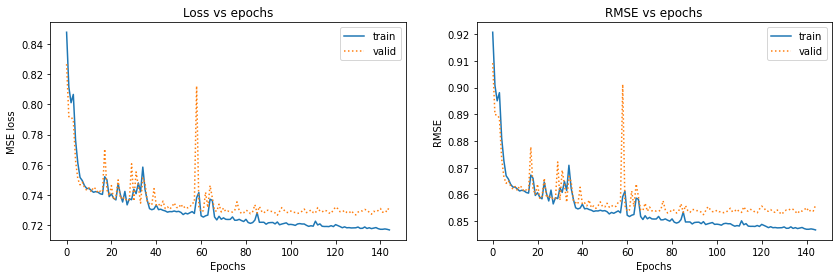

{'loss': 0.73260498046875, 'root_mean_squared_error': 0.8559234738349915}


In [49]:
#load history from logs
large_multi_history = pd.read_csv("../../saved_logs/Tuned_multi_mlp/large_multi_8_32_128_512_2048.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_multi_mlp.evaluate(large_val_dataset, return_dict=True, verbose=0))

### VII.1.d Large correlated dataset

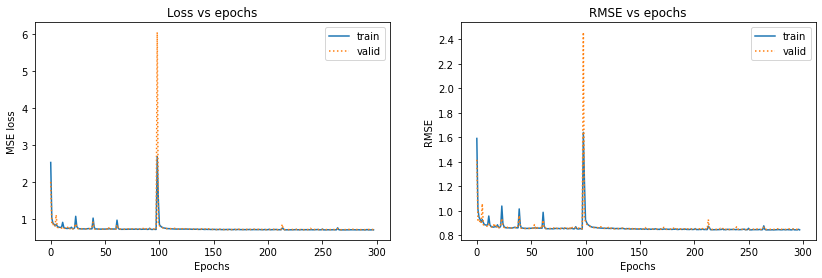

{'loss': 0.7202244400978088, 'root_mean_squared_error': 0.848660409450531}


In [50]:
#load history from logs
large_corr_multi_history = pd.read_csv("../../saved_logs/Tuned_multi_mlp/large_corr_multi_8_32_128_512_2048.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(large_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(large_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(large_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(large_corr_multi_mlp.evaluate(large_corr_val_dataset, return_dict=True, verbose=0))

### VII.1.e Extra small independent dataset

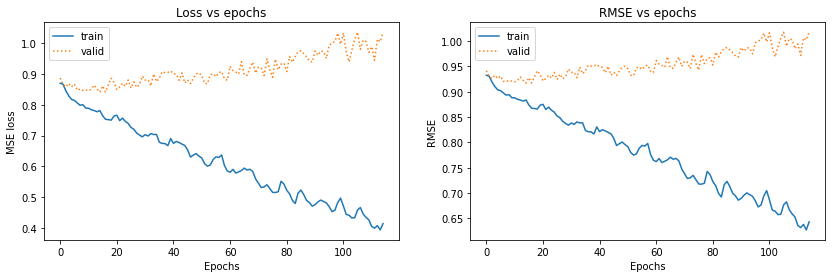

{'loss': 1.0349886417388916, 'root_mean_squared_error': 1.0173438787460327}


In [46]:
#load history from logs
xsmall_multi_history = pd.read_csv("../../saved_logs/Tuned_multi_mlp/extra_small_multi_8_32_128_512_2048.csv")
fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_multi_mlp.evaluate(xsmall_val_dataset, return_dict=True, verbose=0))

### VII.1.f Extra small correlated dataset

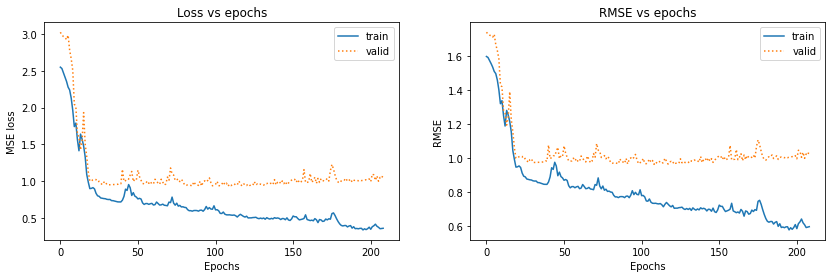

{'loss': 1.083707571029663, 'root_mean_squared_error': 1.0410127639770508}


In [47]:
#load history from logs
xsmall_corr_multi_history = pd.read_csv("../../saved_logs/Tuned_multi_mlp/extra_small_corr_multi_8_32_128_512_2048.csv")

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(xsmall_corr_multi_history['loss'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_loss'], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(xsmall_corr_multi_history['root_mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(xsmall_corr_multi_history['val_root_mean_squared_error'], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(xsmall_corr_multi_mlp.evaluate(xsmall_corr_val_dataset, return_dict=True, verbose=0))

---
# VIII. Load saved models

## VIII.1 Multi Output MLPs

In [54]:
xsmall_multi_status = (tf.train.Checkpoint(model=xsmall_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../../saved_models/Tuned_multi_mlp/extra_small_multi_8_32_128_512_2048'))
                      .expect_partial())
xsmall_multi_status.assert_existing_objects_matched()
xsmall_corr_multi_status = (tf.train.Checkpoint(model=xsmall_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../../saved_models/Tuned_multi_mlp/extra_small_corr_multi_8_32_128_512_2048'))
                           .expect_partial())
xsmall_corr_multi_status.assert_existing_objects_matched()
large_multi_status = (tf.train.Checkpoint(model=large_multi_mlp)
                      .restore(tf.train.latest_checkpoint('../../saved_models/Tuned_multi_mlp/large_multi_8_32_128_512_2048'))
                      .expect_partial())
large_multi_status.assert_existing_objects_matched()
large_corr_multi_status = (tf.train.Checkpoint(model=large_corr_multi_mlp)
                           .restore(tf.train.latest_checkpoint('../../saved_models/Tuned_multi_mlp/large_corr_multi_8_32_128_512_2048'))
                           .expect_partial())

---
# XI. Performances:

## XI.1. Total RMSE on independent dataset

In [55]:
inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [56]:
models = ['MLP multi-output']

training_datasets = ['Extra small independent', 'Extra small correlated',
                     'Large independent', 'Large correlated']

total_rmse_inde = [[inde_rmse_xsmall_multi_mlp, inde_rmse_xsmall_corr_multi_mlp, inde_rmse_large_multi_mlp,
                    inde_rmse_large_corr_multi_mlp]]

In [57]:
table_total_rmse_inde = pd.DataFrame(total_rmse_inde,
                                     index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_inde.style.set_caption("Total RMSE evaluated on simulated normal urine with independent metbaolites")

Training sets,Extra small independent,Extra small correlated,Large independent,Large correlated
Models,,,,
MLP multi-output,0.924053,0.971298,0.850014,0.851161


## XI.2. Total RMSE on correlated dataset

In [58]:
corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [59]:
total_rmse_corr = [[corr_rmse_xsmall_multi_mlp, corr_rmse_xsmall_corr_multi_mlp, corr_rmse_large_multi_mlp, 
                    corr_rmse_large_corr_multi_mlp]]

In [60]:
table_total_rmse_corr = pd.DataFrame(total_rmse_corr, index=pd.Index(models, name='Models'),
                                     columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_corr.style.set_caption("Total RMSE evaluated on simulated normal urine with correlated metbaolites")

Training sets,Extra small independent,Extra small correlated,Large independent,Large correlated
Models,,,,
MLP multi-output,1.687575,0.993129,1.638616,0.847457


## XI.3. Total RMSE on abnormal independent dataset

In [61]:
abn_inde_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_inde_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_inde_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [62]:
total_rmse_abn_inde = [[abn_inde_rmse_xsmall_multi_mlp, abn_inde_rmse_xsmall_corr_multi_mlp,
                        abn_inde_rmse_large_multi_mlp, abn_inde_rmse_large_corr_multi_mlp],]

In [63]:
table_total_rmse_abn_inde = pd.DataFrame(total_rmse_abn_inde, index=pd.Index(models, name='Models'),
                                   columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_inde.style.set_caption("Total RMSE evaluated on simulated abnormal urine with independent metbaolites")

Training sets,Extra small independent,Extra small correlated,Large independent,Large correlated
Models,,,,
MLP multi-output,7.608831,7.372810,4.854214,6.646338


## XI.4. Total RMSE on abnromal correlated dataset

In [64]:
abn_corr_rmse_xsmall_multi_mlp = xsmall_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                   verbose=0)['root_mean_squared_error']
abn_corr_rmse_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                            verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_multi_mlp = large_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                verbose=0)['root_mean_squared_error']
abn_corr_rmse_large_corr_multi_mlp = large_corr_multi_mlp.evaluate(abn_test_corr_dataset, return_dict=True,
                                                          verbose=0)['root_mean_squared_error']

In [65]:
total_rmse_abn_corr = [[abn_corr_rmse_xsmall_multi_mlp, abn_corr_rmse_xsmall_corr_multi_mlp,
                        abn_corr_rmse_large_multi_mlp, abn_corr_rmse_large_corr_multi_mlp]]

In [66]:
table_total_rmse_abn_corr = pd.DataFrame(total_rmse_abn_corr, index=pd.Index(models, name='Models'),
                                         columns=pd.Index(training_datasets, name='Training sets'))
table_total_rmse_abn_corr.style.set_caption("Total RMSE evaluated on simulated abnormal urine with correlated metbaolites")

Training sets,Extra small independent,Extra small correlated,Large independent,Large correlated
Models,,,,
MLP multi-output,7.454063,7.234795,4.726552,6.531441


## XI.4. Metabolite wise $R^{2}$ on independent dataset

### XI.4.a Import mean concentration data and metabolites

In [120]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.4.b Extract ground truth from validation set

In [121]:
true_val = []
for batch in test_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [122]:
inde_SS_total = tf.reduce_mean(tf.math.square(y_val), axis=0).numpy()
inde_SS_total = pd.Series(inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.4.c Multi output MLPs

In [123]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_dataset)


inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_multi_mlp), axis=0).numpy()
inde_R_xsmall_multi_mlp = 1 - inde_SS_res_xsmall_multi_mlp/inde_SS_total
inde_R_xsmall_multi_mlp = pd.Series(inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_xsmall_corr_multi_mlp = 1 - inde_SS_res_xsmall_corr_multi_mlp/inde_SS_total
inde_R_xsmall_corr_multi_mlp = pd.Series(inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')


inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_multi_mlp), axis=0).numpy()
inde_R_large_multi_mlp = 1 - inde_SS_res_large_multi_mlp/inde_SS_total
inde_R_large_multi_mlp = pd.Series(inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
inde_R_large_corr_multi_mlp = 1 - inde_SS_res_large_corr_multi_mlp/inde_SS_total
inde_R_large_corr_multi_mlp = pd.Series(inde_R_small_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.4.i Create the table

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
(summary_table_small.style
  .background_gradient(cmap=cm))

In [127]:
def color_traget(cell):
    colors = ['lightgreen' if cell[i] > 0 else 'lightcoral' for i in range(8)] + ['white']
    return ['background-color: %s' % color for color in colors]


def font_min_RMSE(cell):
    fonts = ['bold' if (1 - cell[i]) == min(1 - cell[:8]) else '' for i in range (8)] + ['']
    return ['font-weight: %s' % font for font in fonts]

In [128]:
# target = pd.Series(mean_concentrations/sd_concentrations * 0.3, index=metabolites, name='Target RMSE')

summary_table_xsmall = pd.concat([inde_R_xsmall_multi_mlp,
                                  inde_R_xsmall_corr_multi_mlp,
                                  inde_SS_total], axis=1)
summary_table_large = pd.concat([inde_R_large_multi_mlp,
                                 inde_R_large_corr_multi_mlp,
                                 inde_SS_total], axis=1)

In [129]:
summary_table_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.996117,0.999539,-0.213989,-0.213989,0.996181,0.999425,-0.252829,-0.640598,1.050550
Hippuric_acid,0.995479,0.999025,-0.090747,-0.090747,0.994126,0.998710,-0.127663,-0.510409,0.895423
Citric_acid,0.991461,0.997273,-0.158070,-0.158070,0.958486,0.989199,-0.251529,-0.390202,0.799125
Glycine,0.962363,0.983334,-0.141396,-0.141396,0.933409,0.971525,-0.270842,-0.360442,0.837392
TMAO,0.994994,0.999637,0.020737,0.020737,0.992526,0.999678,-0.175467,-0.098787,0.663882
Histidine,0.914374,0.964057,-0.093185,-0.093185,0.921329,0.964847,-0.116149,-0.297428,0.981033
phenylacetylglutamine,0.503994,0.718458,-0.084918,-0.084918,0.587950,0.714317,-0.158965,-0.411180,0.991677
Taurine,0.951296,0.981012,-0.042625,-0.042625,0.963507,0.989081,-0.177466,-0.238883,0.803844
glycolic_acid,0.884073,0.939169,-0.076701,-0.076701,0.822245,0.932560,-0.168997,-0.209554,0.938590
Formate,0.676787,0.004972,-0.114814,-0.114814,0.688707,0.784752,-0.148884,-0.198579,0.896775


In [131]:
summary_table_large.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.998075,0.999837,-0.302315,-1.046440,0.998566,0.999943,-0.238343,-0.707005,1.050550
Hippuric_acid,0.998223,0.999850,-0.157913,-0.935911,0.994063,0.999874,-0.181402,-0.803100,0.895423
Citric_acid,0.997500,0.999319,-0.142388,-0.929662,0.995332,0.999399,-0.236714,-0.453613,0.799125
Glycine,0.994048,0.995132,-0.161687,-1.097659,0.992944,0.997402,-0.314957,-0.419880,0.837392
TMAO,0.997133,0.999858,-0.011719,-0.794056,0.996621,0.999966,0.002510,-0.262713,0.663882
Histidine,0.990686,0.997725,-0.217340,-0.931742,0.991112,0.997754,-0.168450,-0.737522,0.981033
phenylacetylglutamine,0.980522,0.982764,-0.318192,-0.924830,0.953213,0.984157,-0.038274,-0.696221,0.991677
Taurine,0.995433,0.999454,-0.049443,-0.896947,0.989238,0.998768,-0.109960,-0.513910,0.803844
glycolic_acid,0.994789,0.997924,-0.158634,-1.101864,0.990180,0.998432,-0.080028,-0.028095,0.938590
Formate,0.991315,0.991146,-0.100892,-1.114016,0.968387,0.995779,-0.097324,-0.046312,0.896775


## XI.5. Metabolite wise RMSE on correlated dataset

### XI.5.a Import mean concentration data and metabolites

In [132]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.5.b Extract ground truth from validation set

In [133]:
true_val = []
for batch in test_corr_dataset:
    true_val.append(batch[1])
y_val_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [134]:
corr_SS_total = tf.reduce_mean(tf.math.square(y_val_corr), axis=0).numpy()
corr_SS_total = pd.Series(corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.5.c Multi output MLPs

In [135]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(test_corr_dataset)



corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_multi_mlp), axis=0).numpy()
corr_R_xsmall_multi_mlp = 1 - corr_SS_res_xsmall_multi_mlp/corr_SS_total
corr_R_xsmall_multi_mlp = pd.Series(corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_xsmall_corr_multi_mlp = 1 - corr_SS_res_xsmall_corr_multi_mlp/corr_SS_total
corr_R_xsmall_corr_multi_mlp = pd.Series(corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_multi_mlp), axis=0).numpy()
corr_R_large_multi_mlp = 1 - corr_SS_res_large_multi_mlp/corr_SS_total
corr_R_large_multi_mlp = pd.Series(corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
corr_R_large_corr_multi_mlp = 1 - corr_SS_res_large_corr_multi_mlp/corr_SS_total
corr_R_large_corr_multi_mlp = pd.Series(corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.5.i Create the table

In [141]:
summary_table_xsmall_corr = pd.concat([corr_R_xsmall_multi_mlp,
                                        corr_R_xsmall_corr_multi_mlp,
                                        corr_SS_total], axis=1)

summary_table_large_corr = pd.concat([corr_R_large_multi_mlp,
                                      corr_R_large_corr_multi_mlp,
                                      corr_SS_total], axis=1)

In [188]:
overlapped_metabolites = [34, 47, 46, 45, 44, 43, 42, 41, 40]
well_resolved_metabolites = [i for i in range(10)]

In [189]:
summary_table_xsmall_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Phenylacetate,-0.441151,-0.060325,-0.089369,-0.089369,-0.576513,-0.052148,-0.112321,-0.205571,1.060587
L-serine,0.205253,0.476192,-0.098780,-0.098780,0.291287,0.486767,-0.208725,-0.135729,0.894521
n-butyrate,-0.553761,-0.103705,-0.101067,-0.101067,-0.448865,-0.262790,-0.238550,-0.427501,0.983673
2_deoxyadenosine,-0.478274,0.002524,-0.105929,-0.105929,-0.457056,-0.123882,-0.194526,-0.260976,0.956117
N-Acetyl-L-aspartic_acid,-0.287055,-0.041413,0.057299,0.057299,-0.574009,0.108893,-0.016513,-0.216992,0.655680
2_deoxycytidine,-0.653043,-0.011705,-0.082976,-0.082976,-0.363053,-0.175754,-0.133299,-0.311130,0.973639
citrulline,-0.384685,-0.001882,-0.125542,-0.125542,-0.400849,-0.108554,-0.106506,-0.145805,0.925322
L-Glutamic_acid,-0.414331,-0.047320,-0.055190,-0.055190,-0.360937,-0.106569,-0.104974,-0.165581,0.982604
Isoleucine,-0.487332,-0.012638,-0.110050,-0.110050,-0.633276,-0.140142,-0.137101,-0.356183,0.970197


In [190]:
summary_table_xsmall_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.994101,0.999360,-0.144342,-0.144342,0.994028,0.999328,-0.227430,-0.856412,1.111394
Hippuric_acid,0.995155,0.999114,-0.080311,-0.080311,0.994248,0.999095,-0.075067,-0.540485,1.142428
Citric_acid,0.992378,0.997836,-0.092943,-0.092943,0.980453,0.996543,-0.187910,-0.742674,1.170822
Glycine,0.968529,0.983941,-0.065414,-0.065414,0.965763,0.984714,-0.115258,-0.283871,2.114304
TMAO,0.994279,0.999722,0.028751,0.028751,0.993792,0.999459,-0.102817,-0.091603,0.673890
Histidine,0.901711,0.953354,-0.119666,-0.119666,0.913494,0.967214,-0.198209,-0.299308,0.917310
phenylacetylglutamine,0.468391,0.675324,-0.119601,-0.119601,0.493260,0.671665,-0.217458,-0.454158,0.919825
Taurine,0.932696,0.969212,-0.032819,-0.032819,0.945839,0.984410,-0.107621,-0.303556,0.758681
glycolic_acid,0.889919,0.943281,-0.065622,-0.065622,0.805894,0.929732,-0.113831,-0.205513,0.966580
Formate,0.635066,0.004874,-0.126718,-0.126718,0.658377,0.783607,-0.200373,-0.228221,0.834259


In [191]:
summary_table_large_corr.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Phenylacetate,0.012258,-0.000479,-0.119392,-0.940233,0.203998,0.293778,-0.119598,-0.019091,1.060587
L-serine,0.954490,0.973314,-0.129225,-0.841177,0.968061,0.959704,-0.113795,-0.150267,0.894521
n-butyrate,-0.012079,-0.001771,-0.135279,-0.250406,-0.019102,0.001319,-0.142249,-0.033046,0.983673
2_deoxyadenosine,-0.006991,0.002047,-0.051550,-0.305481,-0.013214,0.002056,-0.090751,-0.018118,0.956117
N-Acetyl-L-aspartic_acid,0.107158,0.239556,0.034479,-1.068362,0.152348,0.127786,0.050307,0.100322,0.655680
2_deoxycytidine,-0.007080,-0.002523,-0.102306,-0.739482,-0.045056,0.001822,-0.099663,-0.012071,0.973639
citrulline,0.000814,0.004219,-0.097892,-0.639730,0.136512,0.233592,-0.096168,-0.034747,0.925322
L-Glutamic_acid,-0.047884,-0.070050,-0.102728,-0.610798,-0.005031,0.008028,-0.125035,-0.038013,0.982604
Isoleucine,-0.056824,0.532163,-0.108317,-0.836411,0.356329,0.452737,-0.138534,-0.029395,0.970197


In [231]:
summary_table_large_corr.iloc[well_resolved_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.988926,0.999779,-0.308826,-1.120593,0.998933,0.999928,-0.378719,-1.017420,1.111394
Hippuric_acid,0.991694,0.999881,-0.093649,-0.938262,0.990588,0.999902,-0.152737,-0.847323,1.142428
Citric_acid,0.988936,0.999540,-0.114160,-1.083824,0.997212,0.999735,-0.512550,-0.899755,1.170822
Glycine,0.992112,0.999504,-0.083211,-0.996319,0.998473,0.999656,-0.543818,-0.262645,2.114304
TMAO,0.989433,0.999943,0.003726,-0.762189,0.998045,0.999941,0.025116,-0.288107,0.673890
Histidine,0.977426,0.997376,-0.217881,-0.972508,0.991994,0.997564,-0.140749,-0.749789,0.917310
phenylacetylglutamine,0.970288,0.980784,-0.421265,-0.960706,0.980746,0.982983,-0.127516,-0.770618,0.919825
Taurine,0.980601,0.985293,-0.108765,-1.029817,0.989587,0.994360,-0.071195,-0.592609,0.758681
glycolic_acid,0.980519,0.994871,-0.073505,-0.954091,0.995345,0.996881,-0.089467,-0.019923,0.966580
Formate,0.983634,0.998318,-0.110692,-0.932515,0.991419,0.996774,-0.115363,-0.019133,0.834259


## XI.6. Metabolite wise RMSE on abnormal independent dataset

### XI.6.a Import mean concentration data and metabolites

In [145]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.6.b Extract ground truth from validation set

In [146]:
true_val = []
for batch in abn_test_dataset:
    true_val.append(batch[1])
y_val_abn = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [147]:
abn_inde_SS_total = tf.reduce_mean(tf.math.square(y_val_abn), axis=0).numpy()
abn_inde_SS_total = pd.Series(abn_inde_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.6.c Multi output MLPs

In [148]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_dataset)


abn_inde_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_multi_mlp), axis=0).numpy()
abn_inde_R_xsmall_multi_mlp = 1 - abn_inde_SS_res_xsmall_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_multi_mlp = pd.Series(abn_inde_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_inde_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_xsmall_corr_multi_mlp = 1 - abn_inde_SS_res_xsmall_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_xsmall_corr_multi_mlp = pd.Series(abn_inde_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_inde_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_multi_mlp), axis=0).numpy()
abn_inde_R_large_multi_mlp = 1 - abn_inde_SS_res_large_multi_mlp/abn_inde_SS_total
abn_inde_R_large_multi_mlp = pd.Series(abn_inde_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_inde_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_inde_R_large_corr_multi_mlp = 1 - abn_inde_SS_res_large_corr_multi_mlp/abn_inde_SS_total
abn_inde_R_large_corr_multi_mlp = pd.Series(abn_inde_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.6.i Create the table

In [152]:
summary_table_abn_xsmall = pd.concat([abn_inde_R_xsmall_multi_mlp,
                                      abn_inde_R_xsmall_corr_multi_mlp,
                                      abn_inde_SS_total], axis=1)
summary_table_abn_large = pd.concat([abn_inde_R_large_multi_mlp,
                                     abn_inde_R_large_corr_multi_mlp,
                                     abn_inde_SS_total], axis=1)

In [153]:
summary_table_abn_xsmall.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.985388,0.998730,0.322927,0.322927,0.992642,0.995563,0.487381,0.949063,6.965968
Hippuric_acid,0.960084,0.977551,-0.096464,-0.096464,0.750690,0.989939,-0.109557,-0.616947,0.857178
Citric_acid,0.921529,0.945620,-0.166629,-0.166629,0.554366,0.925084,0.469366,0.733143,3.215764
Glycine,0.538651,0.985351,-0.108528,-0.108528,-1.423354,0.967103,-0.920070,-0.792767,0.940719
TMAO,0.935107,0.992852,0.053277,0.053277,0.973232,0.998160,0.013049,-0.284775,0.722405
Histidine,0.406976,0.777690,-0.063868,-0.063868,0.384373,0.099809,-0.229977,-0.364971,0.962129
phenylacetylglutamine,-3.875964,-5.264751,-0.164587,-0.164587,-0.599261,0.447306,-0.082392,-2.757341,1.032282
Taurine,0.575388,0.488658,-0.081562,-0.081562,0.660162,0.914565,-0.180079,-1.999700,0.794538
glycolic_acid,-0.830687,-0.620821,-0.081110,-0.081110,-2.036902,-5.751042,-0.102356,-1.543957,0.853602
Formate,-8.877699,-0.011814,-0.079382,-0.079382,-3.675273,-5.568042,-0.396865,-0.129820,0.807626


In [192]:
summary_table_abn_large.iloc[overlapped_metabolites].style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Phenylacetate,0.003826,0.000237,-0.133229,-1.436283,-0.592977,-0.266896,-0.098851,-2.377705,1.004514
L-serine,0.785331,0.989956,-0.111495,-0.849027,0.838941,0.889071,-0.078337,-10.531075,0.915599
n-butyrate,-0.114648,-0.001969,-0.119270,-0.169040,-0.827913,-0.001885,-0.091586,-0.956402,1.019487
2_deoxyadenosine,-0.049611,-0.001251,-0.116262,-1.050044,-0.268126,-0.003116,-0.090572,-1.067715,0.926405
N-Acetyl-L-aspartic_acid,-0.110953,0.189519,0.051206,-0.500538,0.056763,0.116589,0.024335,-3.395356,0.709385
2_deoxycytidine,0.001172,-0.001722,-0.101674,-2.321657,-0.048723,0.000030,-0.112219,-5.098765,0.989644
citrulline,-0.005620,0.001209,-0.074034,-0.981750,0.006701,0.289241,-0.133774,-3.140284,0.883870
L-Glutamic_acid,-0.249988,-0.206528,-0.067607,-0.885978,-0.370981,-0.350224,-0.101114,-5.838807,0.920245
Isoleucine,0.334723,0.825061,0.024414,0.644415,0.379921,0.293821,0.008711,0.582810,33.942586


## XI.7. Metabolite wise RMSE on abnormal correlated dataset

### XI.7.a Import mean concentration data and metabolites

In [156]:
filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
sd_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=2, skiprows=1)
filename_concentrations = '../data/concentration_data/Small_sample/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

### XI.7.b Extract ground truth from validation set

In [157]:
true_val = []
for batch in abn_test_corr_dataset:
    true_val.append(batch[1])
y_val_abn_corr = tf.concat(true_val, axis=0).numpy()

### XI.4.c Total sum of squares

In [158]:
abn_corr_SS_total = tf.reduce_mean(tf.math.square(y_val_abn_corr), axis=0).numpy()
abn_corr_SS_total = pd.Series(abn_corr_SS_total, index=metabolites, name='Total Sum of Squares')

### XI.7.c Multi output MLPs

In [159]:
y_pred_xsmall_multi_mlp = xsmall_multi_mlp.predict(abn_test_corr_dataset)
y_pred_xsmall_corr_multi_mlp = xsmall_corr_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_multi_mlp = large_multi_mlp.predict(abn_test_corr_dataset)
y_pred_large_corr_multi_mlp = large_corr_multi_mlp.predict(abn_test_corr_dataset)



abn_corr_SS_res_xsmall_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_multi_mlp),
                                                       axis=0).numpy()
abn_corr_R_xsmall_multi_mlp = 1 - abn_corr_SS_res_xsmall_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_multi_mlp = pd.Series(abn_corr_R_xsmall_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small set')

abn_corr_SS_res_xsmall_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_xsmall_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_xsmall_corr_multi_mlp = 1 - abn_corr_SS_res_xsmall_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_xsmall_corr_multi_mlp = pd.Series(abn_corr_R_xsmall_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on extra small correlated set')

abn_corr_SS_res_large_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_multi_mlp),
                                                      axis=0).numpy()
abn_corr_R_large_multi_mlp = 1 - abn_corr_SS_res_large_multi_mlp/abn_corr_SS_total
abn_corr_R_large_multi_mlp = pd.Series(abn_corr_R_large_multi_mlp, index=metabolites,
                                         name='R' + chr(0x00B2) + ' muti-output MLP trained on large set')

abn_corr_SS_res_large_corr_multi_mlp = tf.reduce_mean(tf.math.square(y_val_abn_corr - y_pred_large_corr_multi_mlp),
                                                  axis=0).numpy()
abn_corr_R_large_corr_multi_mlp = 1 - abn_corr_SS_res_large_corr_multi_mlp/abn_corr_SS_total
abn_corr_R_large_corr_multi_mlp = pd.Series(abn_corr_R_large_corr_multi_mlp, index=metabolites,
                            name='R' + chr(0x00B2) + ' muti-output MLP trained on large correlated set')

### XI.7.i Create the table

In [164]:
summary_table_abn_xsmall_corr = pd.concat([abn_corr_R_xsmall_multi_mlp,
                                           abn_corr_R_xsmall_corr_multi_mlp,
                                           abn_corr_SS_total], axis=1)

summary_table_abn_large_corr = pd.concat([abn_corr_R_large_multi_mlp,
                                          abn_corr_R_large_corr_multi_mlp,
                                          abn_corr_SS_total], axis=1)

In [165]:
summary_table_abn_xsmall_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on extra small set,R² single-output RF trained on extra small set,R² muti-output RF trained on extra small set,R² PLS trained on extra small set,R² muti-output MLP trained on extra small correlated set,R² single-output RF trained on extra small correlated set,R² muti-output RF trained on extra small correlated set,R² PLS trained on extra small correlated set,Total Sum of Squares
Creatinine,0.972089,0.999859,0.296465,0.296465,0.999529,0.998737,0.467734,0.977383,10.365010
Hippuric_acid,0.963461,0.992666,0.184776,0.184776,0.996068,0.998565,0.284196,0.886113,4.120888
Citric_acid,0.946508,0.949609,-0.167410,-0.167410,0.546912,0.932860,0.238779,0.756245,3.498624
Glycine,0.644503,0.989464,0.065343,0.065343,0.862505,0.998658,0.329968,0.069456,5.458226
TMAO,0.878529,0.994343,0.037914,0.037914,0.977174,0.998196,0.031010,-0.111851,0.709918
Histidine,0.664089,0.744746,-0.074155,-0.074155,0.318442,0.195774,-0.421566,-0.300179,0.982100
phenylacetylglutamine,-4.570798,-5.394792,-0.130063,-0.130063,-1.733569,0.329998,-0.170665,-2.994338,0.976569
Taurine,0.851937,0.614868,-0.081361,-0.081361,0.674127,0.914116,-0.190984,-1.752324,0.755542
glycolic_acid,0.298920,-0.378146,-0.108691,-0.108691,-1.460447,-5.293589,-0.059135,-0.752248,0.921904
Formate,-9.724265,-0.011677,-0.097704,-0.097704,-2.889006,-4.485303,-0.188744,-0.089973,0.903187


In [167]:
summary_table_abn_large_corr.style.apply(color_traget, axis=1).apply(font_min_RMSE, axis=1)

,R² muti-output MLP trained on large set,R² single-output RF trained on large set,R² muti-output RF trained on large set,R² PLS trained on large set,R² muti-output MLP trained on large correlated set,R² single-output RF trained on large correlated set,R² muti-output RF trained on large correlated set,R² PLS trained on large correlated set,Total Sum of Squares
Creatinine,0.862331,0.999991,0.453301,0.999790,0.991587,0.999980,0.682164,0.987766,10.365010
Hippuric_acid,0.681907,0.999991,0.151427,0.999718,0.968488,0.999995,0.066692,0.991260,4.120888
Citric_acid,0.801877,0.999978,0.136994,0.999073,0.997883,0.999959,0.961302,0.965914,3.498624
Glycine,0.927535,0.999957,0.260115,0.996864,0.987397,0.999972,0.828260,-1.751576,5.458226
TMAO,0.580735,0.999934,0.046587,-0.703953,0.939345,0.999969,0.022651,-10.891216,0.709918
Histidine,0.746463,0.995237,-0.104947,-0.912619,0.292585,0.996151,-0.090983,-0.683041,0.982100
phenylacetylglutamine,0.734873,0.969437,-0.489241,-0.946123,0.494521,0.996541,-0.113392,-1.285135,0.976569
Taurine,0.643213,0.993331,-0.093705,-0.899876,0.781114,0.996806,-0.054526,-0.991732,0.755542
glycolic_acid,0.743739,0.998466,-0.069881,-0.952877,0.636335,0.999633,-0.109124,-1.370229,0.921904
Formate,0.734741,0.978857,-0.089861,-1.142632,0.809812,0.994889,-0.105293,-0.832487,0.903187


# Interprete MLP

In [268]:
def saliency_map_multi(model, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(spectrum)
        preds = model(spectrum[tf.newaxis, ...])
        preds = tf.squeeze(preds)
        metabolites = [preds[i] for i in range(48)]
    sms = []
    for i in range(48):
        grads = tape.gradient(metabolites[i], spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

def saliency_map_single(models, spectrum):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    sms = []
    for i in range(48):
        model = models[i]
        with tf.GradientTape() as tape:
            tape.watch(spectrum)
            preds = model(spectrum[tf.newaxis, ...])
            preds = tf.squeeze(preds)
        grads = tape.gradient(preds, spectrum)
        sms.append(tf.math.abs(grads))
    return sms, preds

In [281]:
df_spectrum_metabolites = []
for i in range(4):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))
for i in range(45, 47):
    filename_spectrum_metabolite = '../data/Metabolite_spectrum/metabolite_{}.txt'.format(i)
    data_spectrum_metabolite = np.loadtxt(filename_spectrum_metabolite, dtype=float)
    df_spectrum_metabolites.append(pd.DataFrame(data_spectrum_metabolite))

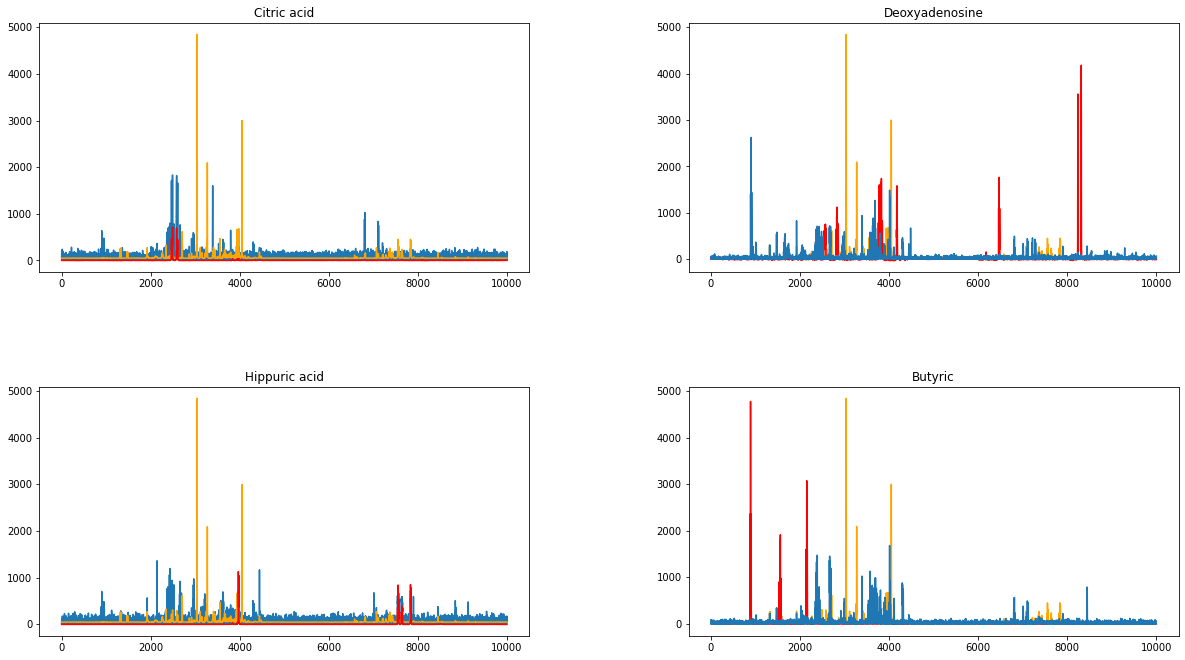

In [313]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_multi(large_multi_mlp, random_spectrum)


fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 300)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 300)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20000, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 4000, color='red')
axs[0, 1].plot(sms[45] * 300)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20000, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 10000, color='red')
axs[1, 1].plot(sms[46] * 300)
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))

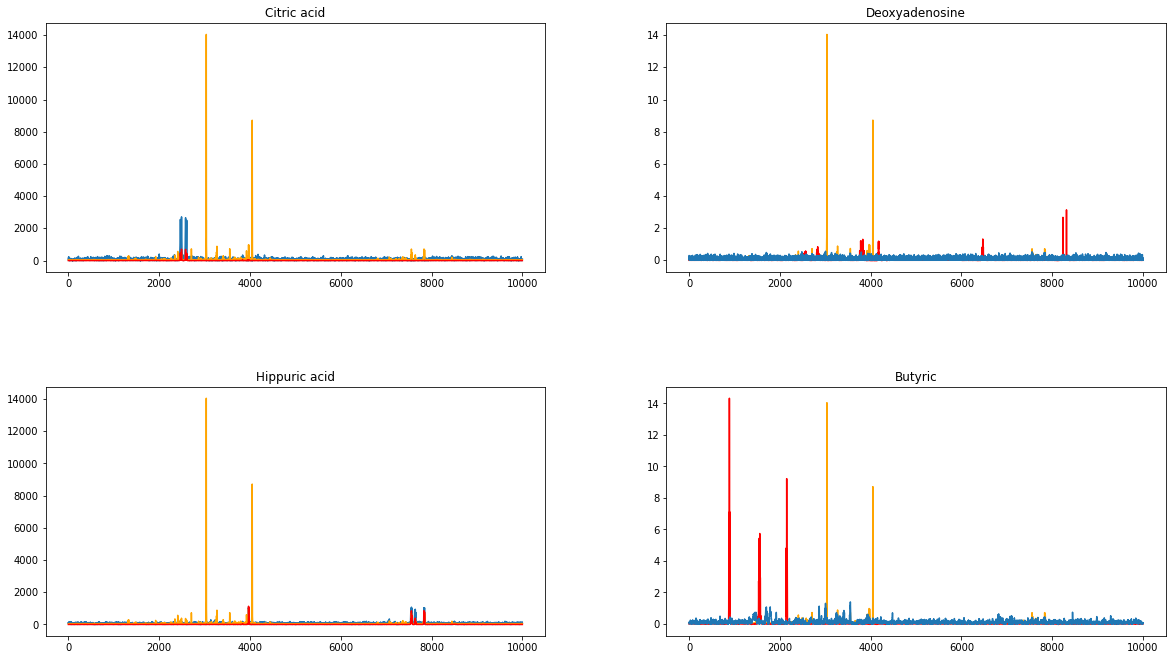

In [309]:
# Compute the saliency map for a randomly selected image
for parsed_record in test_dataset.shuffle(1000).take(1):
    random_spectrum = parsed_record[0][0]
    true_concentration = parsed_record[1][0].numpy()
    sms, pred_concentration = saliency_map_single(xsmall_inde_mlps, random_spectrum)



fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sms[2] * 500)
axs[0, 0].plot(random_spectrum * 20000, color='orange')
axs[0, 0].plot(df_spectrum_metabolites[2], color='red')
axs[0, 0].set_title("Citric acid")
axs[1, 0].plot(sms[1] * 500)
axs[1, 0].plot(random_spectrum * 20000, color='orange')
axs[1, 0].plot(df_spectrum_metabolites[1], color='red')
axs[1, 0].set_title("Hippuric acid")
axs[0, 1].plot(random_spectrum * 20, color='orange')
axs[0, 1].plot(df_spectrum_metabolites[4] * 3, color='red')
axs[0, 1].plot(sms[45] * 10)
axs[0, 1].set_title("Deoxyadenosine")
axs[1, 1].plot(random_spectrum * 20, color='orange')
axs[1, 1].plot(df_spectrum_metabolites[5] * 30, color='red')
axs[1, 1].plot(sms[46])
axs[1, 1].set_title("Butyric")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(12, 5))
# plt.plot(sms[46] * 500)
# plt.plot(random_spectrum * 20000, color='yellow')
# plt.plot(df_spectrum_creatinine, color='red')
# plt.title("Saliency map of metabolite {}".format(0))



plt.show()

# print("Model predictions:\n{}".format(decoded_preds))